In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder, 
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import CLEAN_DATA
from src.models import train_and_validate_regression_model, organize_results, grid_search_cv_regressor
from src.plots import plot_coefs, plot_residuals, plot_compare_models_metrics, plot_residuals_estimator
from src.utils import dataframe_coefs

In [2]:
df = pd.read_parquet(CLEAN_DATA)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,population_per_household,rooms_per_household,bedrooms_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,6+,2.555556,6.984127,1.023810,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,6+,2.109842,6.238137,0.971880,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,1.5,2.026891,4.294117,1.117647,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,1.5,2.640152,4.242424,1.071970,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,1.5,2.362768,5.343676,1.085919,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17540 entries, 0 to 17539
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17540 non-null  float32 
 1   latitude                  17540 non-null  float32 
 2   housing_median_age        17540 non-null  int8    
 3   total_rooms               17540 non-null  int16   
 4   total_bedrooms            17540 non-null  int16   
 5   population                17540 non-null  int16   
 6   households                17540 non-null  int16   
 7   median_income             17540 non-null  float32 
 8   median_house_value        17540 non-null  int32   
 9   ocean_proximity           17540 non-null  category
 10  median_income_cat         17540 non-null  category
 11  population_per_household  17540 non-null  float32 
 12  rooms_per_household       17540 non-null  float32 
 13  bedrooms_per_household    17540 non-null  floa

### separando colunas para diferentes processamentos

In [4]:
# coluna do target
column_target = ['median_house_value']

# colunas categóricas ordinárias - ordinal encoder
columns_cat_ordinal = ['median_income_cat']

#colunas categóricas nominais - one hot encoder
columns_cat_nominal = ['ocean_proximity']

# colunas numéricas para robust scaler
columns_robust_scaler = df.columns.difference(column_target + columns_cat_ordinal + columns_cat_nominal)

In [5]:
pipe_poly = Pipeline(steps=[
    ('robust_scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])

prep = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', OrdinalEncoder(categories='auto'), columns_cat_ordinal),
        ('one_hot_encoder', OneHotEncoder(drop='first'), columns_cat_nominal),
        ('robust_scaler_poly', pipe_poly, columns_robust_scaler),
    ],
)

In [6]:
X = df.drop(columns=column_target)
y = df[column_target]

X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,population_per_household,rooms_per_household,bedrooms_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,6+,2.555556,6.984127,1.023810,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,6+,2.109842,6.238137,0.971880,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,1.5,2.026891,4.294117,1.117647,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,1.5,2.640152,4.242424,1.071970,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,1.5,2.362768,5.343676,1.085919,0.203216


In [7]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


### Testando diferentes reg para o transformers 

In [8]:
param_grid = {
    'regressor__preprocessor__robust_scaler_poly__poly__degree': [1, 2, 3],
    'regressor__reg__alpha': [1E-2, 5E-1, 0.1, 0.25, 0.5 , 1.0],
    'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [9]:
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    param_grid=param_grid,
    preprocessor=prep,
    target_transformer=QuantileTransformer(output_distribution='normal'),
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.5, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [10]:
grid_search.fit(X,y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e+01, tolerance: 1.436e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e+02, tolerance: 1.415e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number o

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_sc...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.5, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [11]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

tendência para o Ridge

In [12]:
grid_search.best_score_

np.float64(-51144.56864638466)

### Verificando coefs

<Axes: title={'center': 'coefs'}, xlabel='coefficients'>

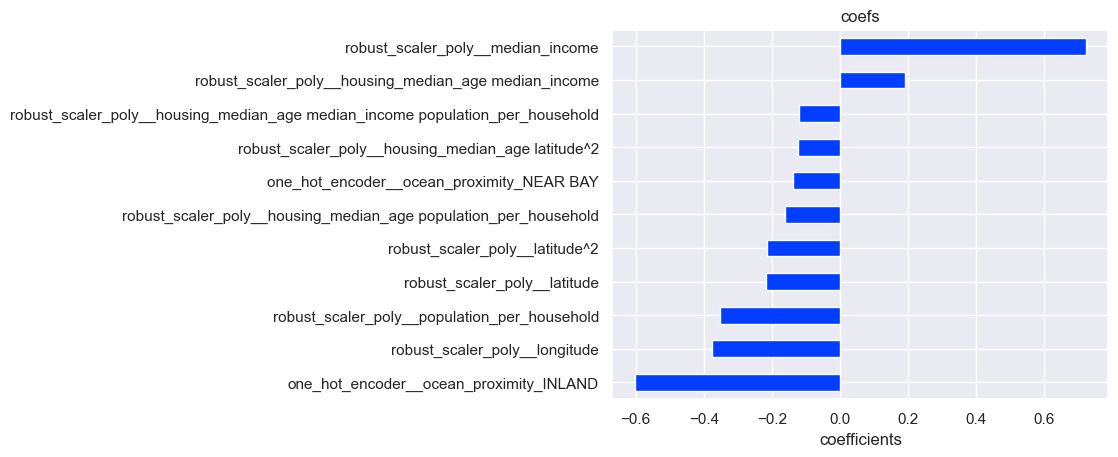

In [18]:
coefs = dataframe_coefs(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

coefs = coefs[~coefs['coefficients'].between(-0.1, 0.1)] # filtrar para os coefs com maiores índices

plot_coefs(coefs)

### Testando modelos básicos com Dummy Regressor e Grid Search

In [19]:
regressors = {
    'DummyRegressor': {
        'preprocessor': None,
        'regressor': DummyRegressor(),
        'target_transformer': None
    },
    'LinearRegression': {
        'preprocessor': prep,
        'regressor': LinearRegression(),
        'target_transformer': None
    },
    'LinearRegression_target': {
        'preprocessor': prep,
        'regressor': LinearRegression(),
        'target_transformer': QuantileTransformer(output_distribution='normal')
    },
    'Elastic_net_grid_search': {
        'preprocessor': grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer': grid_search.best_estimator_.transformer_
    },
}

In [20]:
results = {
    name: train_and_validate_regression_model(X, y, **reg)
    for name, reg in regressors.items()
}

df_results = organize_results(results)
df_results

/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e+01, tolerance: 1.421e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.664e+02, tolerance: 1.415e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tiagoprysthon/anaconda3/envs/machine_learning/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number o

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.003725,0.004537,-0.000023,-75344.044088,-94652.640506,0.008262
1,DummyRegressor,0.002608,0.002701,-0.000097,-77815.127629,-97815.256263,0.005309
2,DummyRegressor,0.002536,0.002727,-0.000306,-76136.496188,-94937.860727,0.005263
3,DummyRegressor,0.002005,0.002627,-0.000177,-77950.972211,-97233.485191,0.004632
4,DummyRegressor,0.001793,0.002325,-0.000351,-76205.284096,-95116.688912,0.004118
5,LinearRegression,0.028082,0.004937,0.675141,-39557.794793,-53948.002416,0.033019
6,LinearRegression,0.017949,0.003631,0.657973,-41974.513255,-57202.61032,0.02158
7,LinearRegression,0.014747,0.003269,0.677336,-40330.004528,-53919.80884,0.018016
8,LinearRegression,0.014562,0.002981,0.668384,-41296.628579,-55988.011805,0.017543
9,LinearRegression,0.013992,0.003021,0.669717,-40331.285373,-54654.198752,0.017013


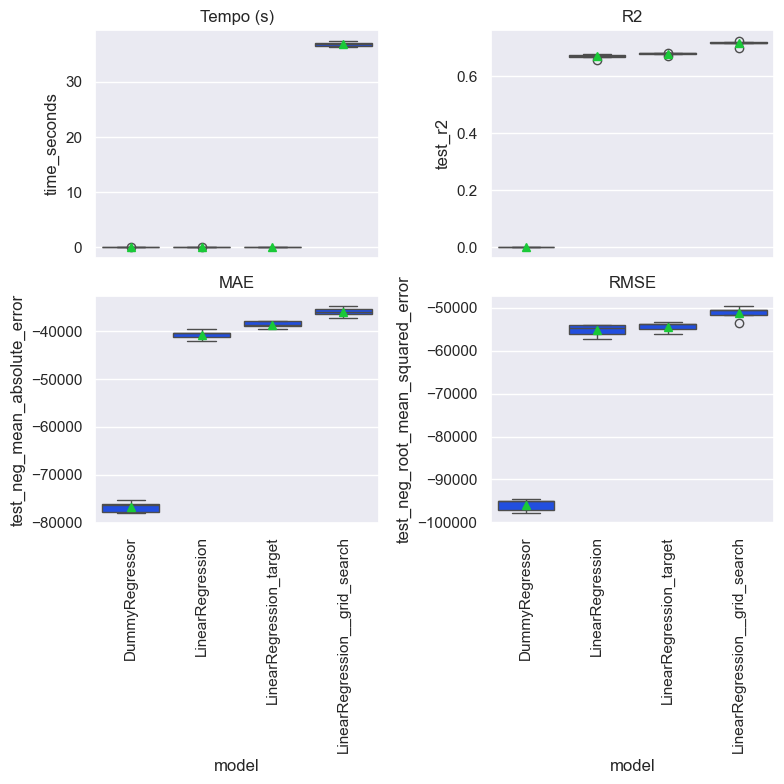

In [21]:
plot_compare_models_metrics(df_results)

maior rendimento, porém com maior custo do tempo

### Verificando resíduos do best estimator

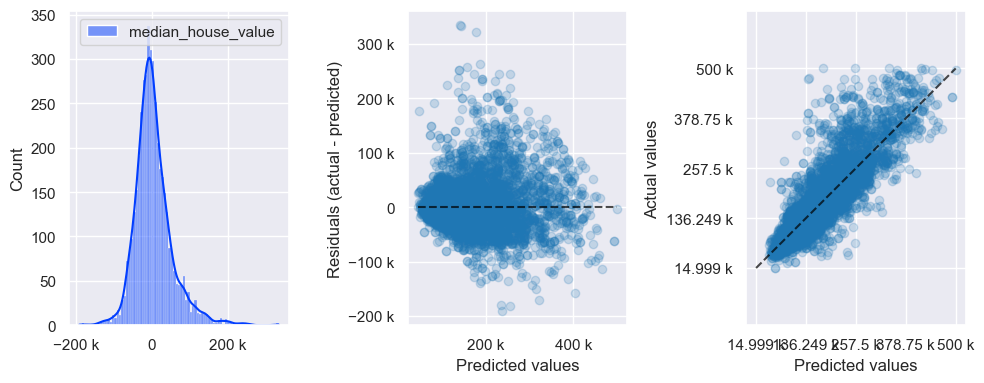

In [22]:
plot_residuals_estimator(grid_search.best_estimator_, X, y)